In [1]:
import os
import pandas as pd
#import pingouin as pg
import numpy as np
from tqdm import tqdm
from neuroCombat import neuroCombat

from concurrent.futures import ThreadPoolExecutor
import concurrent
NUM_WORKERS = 16

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
JUDGES = ["t2w_nfs", "t2w_fs"]
TISSUES = ["csf", "gm", "wm", "gwm", "brain"]
CORRECTION_ROI = ["none", "default", "brain", "gwm"]
NORM_ROI = ["none", "brain", "gwm", "gm", "wm"]

MASK_STRINGS = ["diagnostics", "Unnamed", "id", "sequence", "tissue", "bias_correction", "norm_roi"]


# Utils

In [4]:
def ccc(y1, y2, axis=-1):
    
    e = 1e-12
    
    mean_1 = np.mean(y1, axis=axis).reshape(-1, 1)
    mean_2 = np.mean(y2, axis=axis).reshape(-1, 1)
    
    var_1 = (np.std(y1, axis=axis)**2).reshape(-1,1)
    var_2 = (np.std(y2, axis=axis)**2).reshape(-1,1)

    covar_12 = np.mean((y1-mean_1)*(y2-mean_2), axis=axis).reshape(-1,1)
    
    numerator = 2 * covar_12
    denominator = var_1 + var_2 + (mean_1 - mean_2)**2
    

    return numerator/(denominator+e)

In [5]:
#A small util for masking feats

def get_columns(df, masks):
    
    out_columns = []

    for column in df.columns.to_list():

        for mask in masks:
            flag = False
            if mask in column:
                flag = True
                break;
                
        if not flag:
            out_columns.append(column)
            
    return out_columns



# Visualizing the impact of ComBat harmonization

In [6]:
import seaborn as sns

In [7]:
feats_df = pd.read_csv("results/radiomicsFeatures3D.csv", index_col = 0)
features = get_columns(feats_df, MASK_STRINGS)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Feature: original_glrlm_GrayLevelNonUniformityNormalized 


/home/thulasiseetha/research/venvs/myenv/lib/python3.7/site-packages/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


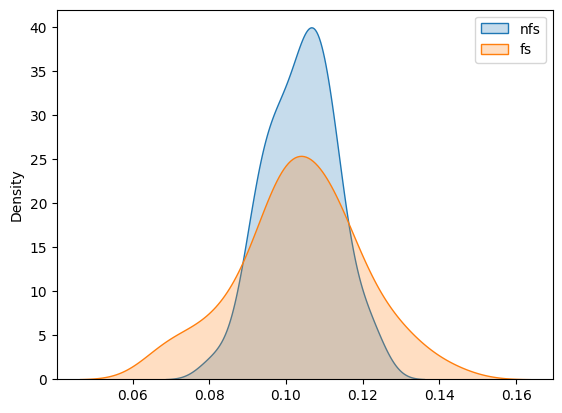

Feature: original_glrlm_GrayLevelNonUniformityNormalized with ComBat


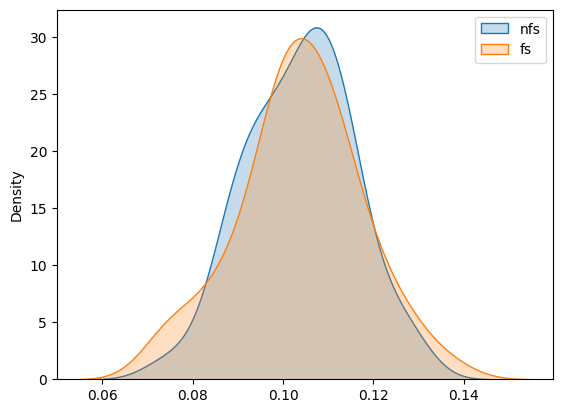

In [8]:
for correction_roi in ["none"]:
    
    for norm_roi in ["none"]:
        
        for tissue in ["gwm"]:
 
            sub_df = feats_df[(feats_df.bias_correction==correction_roi)&(feats_df.norm_roi==norm_roi)&(feats_df.tissue==tissue)].reset_index()
            sub_df["judge"] = sub_df["sequence"].apply(lambda x:JUDGES.index(x))
        
            data = sub_df[features]
            covars = sub_df[["sequence"]]
            combat_sub_npy = neuroCombat(dat=data.T, covars = covars, batch_col="sequence")["data"].T
            combat_sub_df = pd.DataFrame(combat_sub_npy, columns = features)
            combat_sub_df[["id", "judge"]] = sub_df[["id", "judge"]]
            
            normal_sub_df = sub_df[features+["id", "judge"]]
            
            sub_df_dict = {"normal":normal_sub_df, "combat":combat_sub_df}

            for sub_df_type in sub_df_dict:
                
                _sub_df = sub_df_dict[sub_df_type]
                
                for feat in features[55:]:
         
                    judge0_ratings = _sub_df[_sub_df.judge==0].sort_values(by="id")[feat].values
                    judge1_ratings = _sub_df[_sub_df.judge==1].sort_values(by="id")[feat].values

                    print(f"Feature: {feat} "+("with ComBat" if sub_df_type=="combat" else ""))
                    
                    ax = plt.figure().gca()
                    
                    sns.kdeplot(judge0_ratings, label=JUDGES[0].split("_")[-1], fill=True, ax=ax)
                    sns.kdeplot(judge1_ratings, label=JUDGES[1].split("_")[-1], fill=True, ax=ax)
                    
                    ax.legend()
                    plt.show()
                    
                    break;
                
            

# Combat Harmonization + CCC Estimation

In [9]:
stability_df = {"bias_correction":[], "normalization":[], "tissue":[], "type":[], "feature":[], "ccc":[]}

pbar = tqdm(range(len(features)*len(CORRECTION_ROI)*len(NORM_ROI)*len(TISSUES)*2), desc="estimating stability", position=0)

for correction_roi in CORRECTION_ROI:
    
    for norm_roi in NORM_ROI:
        
        for tissue in TISSUES:
 
            sub_df = feats_df[(feats_df.bias_correction==correction_roi)&(feats_df.norm_roi==norm_roi)&(feats_df.tissue==tissue)].reset_index()
            sub_df["judge"] = sub_df["sequence"].apply(lambda x:JUDGES.index(x))
        
            data = sub_df[features]
            covars = sub_df[["sequence"]]
            combat_sub_npy = neuroCombat(dat=data.T, covars = covars, batch_col="sequence")["data"].T
            combat_sub_df = pd.DataFrame(combat_sub_npy, columns = features)
            combat_sub_df[["id", "judge"]] = sub_df[["id", "judge"]]
            
            normal_sub_df = sub_df[features+["id", "judge"]]
            
            sub_df_dict = {"normal":normal_sub_df, "combat":combat_sub_df}

            for sub_df_type in sub_df_dict:
                
                _sub_df = sub_df_dict[sub_df_type]
                
                for feat in features:
                    
                    judge0_ratings = _sub_df[_sub_df.judge==0].sort_values(by="id")[feat].values
                    judge1_ratings = _sub_df[_sub_df.judge==1].sort_values(by="id")[feat].values
                    
                    ccc_estimate = ccc(judge0_ratings, judge1_ratings)
                    
                    stability_df["bias_correction"].append(correction_roi)
                    stability_df["normalization"].append(norm_roi)
                    stability_df["tissue"].append(tissue)
                    stability_df["type"].append(sub_df_type)
                    stability_df["feature"].append(feat)
                    stability_df["ccc"].append(ccc_estimate.item())

                    pbar.update()



In [10]:
#Exporting as data frame
stability_df = pd.DataFrame.from_dict(stability_df)
stability_df.to_csv("stability_df.csv", index=False)